### Machine Learning Model Development

1. Datasource:
    - https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset

2. Objective:
    - To classify a person into abnormal or normal using collected physical spine data.
    
3. Metrics:
    - For medical datasets, it is important to reduce False Negative i.e. a Patient must not be mis classified as normal.
    - In other words, typically Recall must be improved.
    - Evaluation Metric for Hyperparameter tuning is set as f1 score.
    
4. Scope:
    - Limited to the models used with hyperparameter tuning with few parameters and levels.(Hardware limitations)

5. Target:
    - Good balance between Recall & Precision. i.e. f1-score >= 80%
    - Difference between Train-Test Accuracy <= 5%
    
6. Recommendation from Exploratory Data Analyses (EDA)
    - Drop pelvic_incidence
    - Use StandarScaler.
    - Downsampling / Upsampling.
    
7. Boundary Conditions:
    1. Train-Test Split: 80-20 with Stratification of y
    2. Encoding: Normal = 0 | Abnormal(Patient) = 1
    3. Imputing: Not Required.
    4. Outliers Removed: No.
    5. Up / Down Sampling: Up Sampling. i.e. minority class is upsampled.
    6. Scaler: StandardScaler
    7. Hyperparameter Tuning Metrics: accuracy.
    

In [1]:
# Import Relevant Libraries

# -------------- Basic Libraries ----------------------
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', 10000)
pd.options.display.width=None
from tabulate import tabulate
tabulate.PRESERVE_WHITESPACE = False

from scipy import stats

# --------------- sklearn libraries ---------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm

# --------------- End of sklearn libraries ---------------------

import catboost as cb

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Sequential

import shap

In [2]:
# Global constants

RND_STATE = 39  # random_state where used is assigned RND_STATE
TESTSIZE = 0.2  # test_size where used is assigned TESTSIZE

In [3]:
PATH = r"C:\DSML_Case_Studies\01_Classification\01_Dataset"
OUTPATH = r"C:\DSML_Case_Studies\01_Classification\03_Output"
DATASET = r"\Dataset_Lower_Back_Pain_12x1.csv"
PREFIX = r"\Back_Pain_"

# Specify number of features and targets

n_features = 12
n_target = 1

In [4]:
# Dataframe Definition & Classifying Features & Targets

df = pd.read_csv(f"{PATH}{DATASET}")
df = df.round(decimals=3)

collst = []
for columns in df.columns:
    collst.append(columns)

featlst = collst[0:len(collst)-n_target]
targlst = collst[-n_target:]

cat_df = df.select_dtypes(include=['object'])
catlst = []
for col in cat_df.columns:
    catlst.append(col)

y_catlst = [value for value in catlst if value in targlst]

In [5]:
print("Dataframe BEFORE Encoding: ")

Dataframe BEFORE Encoding: 


In [6]:
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Class_att
0,47.806,10.689,54.000,37.117,125.391,-0.403,0.750,32.811,12.050,15.659,-4.137,39.620,Normal
1,92.026,35.393,77.417,56.634,115.724,58.058,0.302,30.016,9.832,11.212,-19.265,19.997,Patient
2,63.792,21.345,66.000,42.447,119.550,12.383,0.608,21.560,8.023,8.727,-8.842,34.572,Normal
3,46.390,11.079,32.137,35.311,98.775,6.387,0.065,14.283,7.452,7.302,-24.361,28.237,Patient
4,64.624,15.225,67.632,49.399,90.298,31.326,0.782,24.763,18.598,13.018,-20.526,17.355,Patient


In [7]:
# Encode Categorical Columns

for i in range(0, len(collst), 1):
    temp = df.dtypes[collst[i]]
    if temp == 'object':
        df[collst[i]] = df[collst[i]].astype('category')
        df[collst[i]] = df[collst[i]].cat.codes
    else:
        continue
        
# Features & Target DataFrame

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

In [8]:
print("Dataframe AFTER Encoding: ")

Dataframe AFTER Encoding: 


In [9]:
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Class_att
0,47.806,10.689,54.000,37.117,125.391,-0.403,0.750,32.811,12.050,15.659,-4.137,39.620,0
1,92.026,35.393,77.417,56.634,115.724,58.058,0.302,30.016,9.832,11.212,-19.265,19.997,1
2,63.792,21.345,66.000,42.447,119.550,12.383,0.608,21.560,8.023,8.727,-8.842,34.572,0
3,46.390,11.079,32.137,35.311,98.775,6.387,0.065,14.283,7.452,7.302,-24.361,28.237,1
4,64.624,15.225,67.632,49.399,90.298,31.326,0.782,24.763,18.598,13.018,-20.526,17.355,1


In [10]:
print("Dataframe BEFORE Imputing: ")

Dataframe BEFORE Imputing: 


In [11]:
print(df.isnull().sum(), end='\n\n')

pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
pelvic_slope                0
Direct_tilt                 0
thoracic_slope              0
cervical_tilt               0
sacrum_angle                0
scoliosis_slope             0
Class_att                   0
dtype: int64



In [12]:
# Basic Imputing

''' Use Appropriate Imputer - Mean, Meadian, Mode... Others '''

df = df.apply(lambda x: x.fillna(x.median()), axis=0)

In [13]:
print("Dataframe AFTER MEDIAN Imputing: ")

Dataframe AFTER MEDIAN Imputing: 


In [14]:
print(df.isnull().sum(), end='\n\n')

pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
pelvic_slope                0
Direct_tilt                 0
thoracic_slope              0
cervical_tilt               0
sacrum_angle                0
scoliosis_slope             0
Class_att                   0
dtype: int64



In [15]:
"""
    1. Cell for removing outliers.
    2. Based on Z-score.
"""
# df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)] # Removing the Outliers using Z-Scored Method

'\n    1. Cell for removing outliers.\n    2. Based on Z-score.\n'

In [16]:
# Sanity checks before proceeding further

print("List of Features:", featlst, end='\n\n')
print("List of Targets:", targlst, end='\n\n')
print("List of Categorical Variables:", catlst, end='\n\n')
print("List of Categorical Targets", y_catlst, end='\n\n')

List of Features: ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'pelvic_slope', 'Direct_tilt', 'thoracic_slope', 'cervical_tilt', 'sacrum_angle', 'scoliosis_slope']

List of Targets: ['Class_att']

List of Categorical Variables: ['Class_att']

List of Categorical Targets ['Class_att']



In [17]:
print("Descriptive Stats: ")

Descriptive Stats: 


In [18]:
desc_stat = df.describe().T.round(3) # Univariate analyses
print(tabulate(desc_stat, headers=desc_stat.columns, tablefmt="github", numalign="right"))

|                          |   count |    mean |    std |     min |     25% |     50% |     75% |     max |
|--------------------------|---------|---------|--------|---------|---------|---------|---------|---------|
| pelvic_incidence         |     310 |  60.497 | 17.237 |  26.148 |   46.43 |  58.692 |  72.878 | 129.834 |
| pelvic_tilt              |     310 |  17.543 | 10.008 |  -6.555 |  10.667 |  16.358 |   22.12 |  49.432 |
| lumbar_lordosis_angle    |     310 |  51.931 | 18.554 |      14 |      37 |  49.562 |      63 | 125.742 |
| sacral_slope             |     310 |  42.954 | 13.423 |  13.367 |  33.347 |  42.405 |  52.696 |  121.43 |
| pelvic_radius            |     310 | 117.921 | 13.317 |  70.083 | 110.709 | 118.268 | 125.468 | 163.071 |
| degree_spondylolisthesis |     310 |  26.297 | 37.559 | -11.058 |   1.604 |  11.768 |  41.288 | 418.543 |
| pelvic_slope             |     310 |   0.473 |  0.286 |   0.003 |   0.225 |   0.476 |   0.705 |   0.999 |
| Direct_tilt              |

In [19]:
# Train-Test Split

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TESTSIZE, random_state=RND_STATE, stratify=y)


In [20]:
# Over Sampling

from imblearn.over_sampling import RandomOverSampler

y_score = y_train.iloc[:, -1].value_counts()

In [21]:
print("****** Before Upsampling ******")

****** Before Upsampling ******


In [22]:
y_score

1    168
0     80
Name: Class_att, dtype: int64

In [23]:
ros = RandomOverSampler(random_state=RND_STATE)
X_train, y_train = ros.fit_resample(X_train, y_train)

y_score = y_train.iloc[:, -1].value_counts()

In [24]:
print("****** After Upsampling ******")

****** After Upsampling ******


In [25]:
y_score

0    168
1    168
Name: Class_att, dtype: int64

In [26]:
# # Under Sampling

# from imblearn.under_sampling import RandomUnderSampler

# y_score = y_train.iloc[:, -1].value_counts()

# print("Before Downsampling:", y_score)

# rus = RandomUnderSampler(random_state=RND_STATE)
# X_train, y_train = rus.fit_resample(X_train, y_train)

# y_score = y_train.iloc[:, -1].value_counts()

# print("After Undersampling:", y_score)

In [27]:
print("Train Dataset - Features: ")

Train Dataset - Features: 


In [28]:
X_train.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
0,71.187,23.896,43.697,47.291,119.865,27.284,0.402,9.130,16.717,7.031,-4.667,14.534
1,55.512,20.095,44.000,35.417,122.649,34.553,0.672,35.091,8.657,14.358,-33.991,25.522
2,74.565,15.724,58.619,58.841,105.417,0.599,0.118,18.055,15.624,10.546,-32.495,16.623
3,69.563,15.401,74.438,54.162,105.067,29.701,0.003,13.359,18.266,15.383,-2.504,14.256
4,67.805,16.551,43.257,51.254,119.686,4.868,0.036,18.489,15.402,13.866,-17.473,39.353


In [29]:
print("Test Dataset - Features: ")

Test Dataset - Features: 


In [30]:
X_test.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
289,72.644,18.929,68.000,53.715,116.963,25.384,0.438,13.012,14.578,13.753,-21.283,41.213
183,42.517,14.376,25.324,28.142,128.906,0.757,0.625,35.634,18.712,8.978,-14.511,22.638
259,79.939,18.774,63.312,61.164,114.787,38.539,0.709,11.294,10.922,7.172,-34.654,28.184
276,64.262,14.498,43.903,49.764,115.388,5.951,0.034,32.261,15.369,16.318,-4.179,32.966
299,74.006,21.122,57.380,52.883,120.206,74.555,0.407,10.590,12.595,15.875,-10.625,31.970


In [31]:
print("Train Dataset - Target: ")

Train Dataset - Target: 


In [32]:
y_train.head()

,Class_att
0,1
1,1
2,0
3,1
4,0


In [33]:
print("Test Dataset - Target: ")

Test Dataset - Target: 


In [34]:
y_test.head()

,Class_att
289,1
183,0
259,1
276,0
299,1


In [35]:
# Scaling

scaler = StandardScaler()
# scaler = MinMaxScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_sc_df = pd.DataFrame(scaler.fit_transform(X_train), columns=featlst)
X_test_sc_df = pd.DataFrame(scaler.transform(X_test), columns=featlst)

In [36]:
print("Train Dataset Scaled - Features:")

Train Dataset Scaled - Features:


In [37]:
X_train_sc_df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
0,0.772661,0.797968,-0.348532,0.413868,0.038300,0.205202,-0.239968,-1.381565,1.104776,-1.650594,0.780777,-1.119418
1,-0.176895,0.394342,-0.331651,-0.523914,0.259625,0.409552,0.680692,1.565110,-1.352227,0.884352,-1.569775,-0.074959
2,0.977293,-0.069812,0.482826,1.326061,-1.110301,-0.544980,-1.208366,-0.368542,0.771587,-0.434498,-1.449859,-0.920849
3,0.674283,-0.104111,1.364160,0.956524,-1.138126,0.273150,-1.600499,-0.901557,1.576971,1.238974,0.954159,-1.145843
4,0.567787,0.018007,-0.373046,0.726857,0.024069,-0.424968,-1.487974,-0.319282,0.703912,0.714133,-0.245726,1.239740


In [38]:
print("Test Dataset Scaled - Features:")

Test Dataset Scaled - Features:


In [39]:
X_test_sc_df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
0,0.860923,0.270525,1.005476,0.921221,-0.192406,0.151788,-0.117214,-0.940943,0.452725,0.675038,-0.551128,1.416541
1,-0.964102,-0.212955,-1.372158,-1.098477,0.757049,-0.540538,0.520429,1.626743,1.712929,-0.976984,-0.008298,-0.349096
2,1.302838,0.254066,0.744290,1.509526,-0.365396,0.521608,0.806856,-1.135942,-0.661766,-1.601812,-1.622920,0.178076
3,0.353161,-0.200000,-0.337055,0.609180,-0.317617,-0.394522,-1.494794,1.243894,0.693853,1.562459,0.819894,0.632627
4,0.943430,0.503399,0.413797,0.855511,0.065409,1.534108,-0.222919,-1.215849,-0.151771,1.409193,0.303196,0.537952


In [ ]:
# Hyperparameter Tuning for Logistic Regression Model

Log_Reg = LogisticRegression()

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [10000, 1000, 100, 10, 1.0]

grid = {'solver':solvers,
       'penalty':penalty,
       'C':c_values,
        'class_weight':[{0:1, 1:w} for w in [1, 2.1]]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=Log_Reg, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

LR_Best = grid_search.best_params_

In [41]:
print("------ Logistic Regression Best Parameters ------")

------ Logistic Regression Best Parameters ------


In [42]:
LR_Best

{'C': 1.0,
 'class_weight': {0: 1, 1: 1},
 'penalty': 'l2',
 'solver': 'liblinear'}

In [43]:
# Model: Logistic Regression (LR)

Log_Reg = LogisticRegression(**LR_Best, random_state=RND_STATE).fit(X_train_sc, y_train)

# Prediction

y_pred = Log_Reg.predict(X_test_sc)

Train_Acc_LR = round(Log_Reg.score(X_train_sc, y_train),2)
Test_Acc_LR = round(Log_Reg.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_LR = CM[1, 1]
TN_LR = CM[0, 0]
FP_LR = CM[0, 1]
FN_LR = CM[1, 0]

Precision_LR = round(TP_LR/(TP_LR + FP_LR), 2)
Recall_LR = round(TP_LR/(TP_LR+FN_LR), 2)
f1_LR = round((2*Precision_LR*Recall_LR)/(Precision_LR+Recall_LR), 2)
Specificity_LR = round(TN_LR/(TN_LR+FP_LR), 2)
AUC_LR = round(roc_auc_score(y_test, y_pred), 2)

fpr_LR, tpr_LR, threshold_LR = roc_curve(y_test, y_pred, pos_label=1)

In [44]:
LR_Rep = classification_report(y_test, y_pred, output_dict=True)
LR_Rep_df = pd.DataFrame(LR_Rep).transpose()

In [45]:
print("-------- Logistic Regression Summary -------- ")

-------- Logistic Regression Summary -------- 


In [46]:
LR_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.62,0.80,0.70,20.00
1,0.89,0.76,0.82,42.00
accuracy,0.77,0.77,0.77,0.77
macro avg,0.75,0.78,0.76,62.00
weighted avg,0.80,0.77,0.78,62.00


In [ ]:
# Hyperparameter Tunining for Random Forest Classifier (RFC)

RFC = RandomForestClassifier()

n_estimators = [200, 600] # Number of Trees in the Forest
max_features = ['auto']
max_depth = [3, 5] # max number of levels in each decision tree
min_samples_split = [2, 5]
criterion = ['entropy', 'gini']
weights = [1, 2.1]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'criterion': criterion,
               'class_weight':  [{0:1, 1:weights} for weights in weights]
       }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=RFC, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

RFC_Best = grid_search.best_params_

In [48]:
print("------ Random Forest Best Parameters ------")

------ Random Forest Best Parameters ------


In [49]:
RFC_Best

{'class_weight': {0: 1, 1: 1},
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 600}

In [50]:
# Model: Random Forest (RFC) 

RFC = RandomForestClassifier(**RFC_Best, random_state=RND_STATE)
RFC.fit(X_train_sc, y_train)

# Prediction

y_pred = RFC.predict(X_test_sc)

Train_Acc_RFC = round(RFC.score(X_train_sc, y_train),2)
Test_Acc_RFC = round(RFC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_RFC = CM[1, 1]
TN_RFC = CM[0, 0]
FP_RFC = CM[0, 1]
FN_RFC = CM[1, 0]

Precision_RFC = round(TP_RFC/(TP_RFC + FP_RFC), 2)
Recall_RFC = round(TP_RFC/(TP_RFC+FN_RFC), 2)
f1_RFC = round((2*Precision_RFC*Recall_RFC)/(Precision_RFC+Recall_RFC), 2)
Specificity_RFC = round(TN_RFC/(TN_RFC+FP_RFC), 2)
AUC_RFC = round(roc_auc_score(y_test, y_pred), 2)

fpr_RFC, tpr_RFC, threshold_RFC = roc_curve(y_test, y_pred, pos_label=1)

In [51]:
RFC_Rep = classification_report(y_test, y_pred, output_dict=True)
RFC_Rep_df = pd.DataFrame(RFC_Rep).transpose()

In [52]:
print("-------- Random Forest Summary -------- ")

-------- Random Forest Summary -------- 


In [53]:
RFC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.67,0.80,0.73,20.00
1,0.89,0.81,0.85,42.00
accuracy,0.81,0.81,0.81,0.81
macro avg,0.78,0.80,0.79,62.00
weighted avg,0.82,0.81,0.81,62.00


In [ ]:
# Hyperparameter Tunining for Extra Trees Classifier (ETC)

ETC = ExtraTreesClassifier()

n_estimators = [200, 600] # Number of Trees in the Forest
max_features = ['auto']
max_depth = [3, 5] # max number of levels in each decision tree
min_samples_split = [2, 5]
criterion = ['entropy', 'gini']
weights = [1, 2.1]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'criterion': criterion,
               'class_weight':  [{0:1, 1:weights} for weights in weights]
       }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=ETC, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

ETC_Best = grid_search.best_params_

In [55]:
print("------ Extra Trees Best Parameters ------")

------ Extra Trees Best Parameters ------


In [56]:
ETC_Best

{'class_weight': {0: 1, 1: 1},
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 600}

In [57]:
# Model: Extra Trees (ETC) 

ETC = RandomForestClassifier(**ETC_Best, random_state=RND_STATE)
ETC.fit(X_train_sc, y_train)

# Prediction

y_pred = ETC.predict(X_test_sc)

Train_Acc_ETC = round(ETC.score(X_train_sc, y_train),2)
Test_Acc_ETC = round(ETC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_ETC = CM[1, 1]
TN_ETC = CM[0, 0]
FP_ETC = CM[0, 1]
FN_ETC = CM[1, 0]

Precision_ETC = round(TP_ETC/(TP_ETC + FP_ETC), 2)
Recall_ETC = round(TP_ETC/(TP_ETC+FN_ETC), 2)
f1_ETC = round((2*Precision_ETC*Recall_ETC)/(Precision_ETC+Recall_ETC), 2)
Specificity_ETC = round(TN_ETC/(TN_ETC+FP_ETC), 2)
AUC_ETC = round(roc_auc_score(y_test, y_pred), 2)

fpr_ETC, tpr_ETC, threshold_ETC = roc_curve(y_test, y_pred, pos_label=1)

In [58]:
ETC_Rep = classification_report(y_test, y_pred, output_dict=True)
ETC_Rep_df = pd.DataFrame(RFC_Rep).transpose()

In [59]:
print("-------- Extra Trees Summary -------- ")

-------- Extra Trees Summary -------- 


In [60]:
ETC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.67,0.80,0.73,20.00
1,0.89,0.81,0.85,42.00
accuracy,0.81,0.81,0.81,0.81
macro avg,0.78,0.80,0.79,62.00
weighted avg,0.82,0.81,0.81,62.00


In [ ]:
# Model: Hyper Parameter Tuning for Kernel Support Vector Machines

KSV = svm.SVC()

kernel = ['linear', 'rbf']
c_values = [1000, 100, 1]
gamma = [0.001, 0.01]
weights = [1, 2.1]

grid = {'kernel':kernel,
       'C':c_values,
        'gamma':gamma,
        'class_weight':[{0:1, 1:weights} for weights in weights]
       }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=KSV, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

KSV_Best = grid_search.best_params_

In [62]:
print("------ Kernel SVM Best Parameters ------")

------ Kernel SVM Best Parameters ------


In [63]:
KSV_Best

{'C': 1000, 'class_weight': {0: 1, 1: 1}, 'gamma': 0.01, 'kernel': 'rbf'}

In [64]:
# Model: Kernel Support Vector (KSV)

KSV = svm.SVC(**KSV_Best, random_state=RND_STATE)
KSV.fit(X_train_sc, y_train)

# Prediction

y_pred = KSV.predict(X_test_sc)

Train_Acc_KSV = round(KSV.score(X_train_sc, y_train),2)
Test_Acc_KSV = round(KSV.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_KSV = CM[1, 1]
TN_KSV = CM[0, 0]
FP_KSV = CM[0, 1]
FN_KSV = CM[1, 0]

Precision_KSV = round(TP_KSV/(TP_KSV + FP_KSV), 2)
Recall_KSV = round(TP_KSV/(TP_KSV+FN_KSV), 2)
f1_KSV = round((2*Precision_KSV*Recall_KSV)/(Precision_KSV+Recall_KSV), 2)
Specificity_KSV = round(TN_KSV/(TN_KSV+FP_KSV), 2)
AUC_KSV = round(roc_auc_score(y_test, y_pred), 2)

fpr_KSV, tpr_KSV, threshold_KSV = roc_curve(y_test, y_pred, pos_label=1)

In [65]:
KSV_Rep = classification_report(y_test, y_pred, output_dict=True)
KSV_Rep_df = pd.DataFrame(KSV_Rep).transpose()

In [66]:
print("-------- Kernel Support Vector Summary -------- ")

-------- Kernel Support Vector Summary -------- 


In [67]:
KSV_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.62,0.65,0.63,20.00
1,0.83,0.81,0.82,42.00
accuracy,0.76,0.76,0.76,0.76
macro avg,0.72,0.73,0.73,62.00
weighted avg,0.76,0.76,0.76,62.00


In [ ]:
# Model: Hyperparameter Tuning for CatBoost Classification (CBC)

train_dataset = cb.Pool(X_train_sc, y_train)
test_dataset = cb.Pool(X_test_sc, y_test)

learning_rate = [0.03, 0.1]
depth= [4, 6, 10]
l2_leaf_reg =  [1, 3, 5,]
iterations = [50, 100, 150]
weights = [1, 2.1]

CBC = cb.CatBoostClassifier(loss_function='Logloss', eval_metric='Accuracy')

grid = {'learning_rate':learning_rate,
        'depth': depth,
        'l2_leaf_reg':l2_leaf_reg,
        'iterations':iterations,
#         'class_weights': [{0:1, 1:weights} for weights in weights]
       }

CBC.grid_search(grid, train_dataset)
CBC.get_params ()
CBC_Best = CBC.get_params()

In [69]:
print("------ CatBoost Classification Best Parameters ------")

------ CatBoost Classification Best Parameters ------


In [70]:
CBC_Best

{'loss_function': 'Logloss',
 'eval_metric': 'Accuracy',
 'depth': 6,
 'l2_leaf_reg': 3,
 'iterations': 50,
 'learning_rate': 0.1}

In [ ]:
# Model: CatBoost Classification (CBC)

CBC= cb.CatBoostClassifier(**CBC_Best, random_seed=RND_STATE)
CBC.fit(X_train_sc, y_train)

# Prediction

y_pred = CBC.predict(X_test_sc)

Train_Acc_CBC = round(CBC.score(X_train_sc, y_train),2)
Test_Acc_CBC = round(CBC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_CBC = CM[1, 1]
TN_CBC = CM[0, 0]
FP_CBC = CM[0, 1]
FN_CBC = CM[1, 0]

Precision_CBC = round(TP_CBC/(TP_CBC + FP_CBC), 2)
Recall_CBC = round(TP_CBC/(TP_CBC+FN_CBC), 2)
f1_CBC = round((2*Precision_CBC*Recall_CBC)/(Precision_CBC+Recall_CBC), 2)
Specificity_CBC = round(TN_CBC/(TN_CBC+FP_CBC), 2)
AUC_CBC = round(roc_auc_score(y_test, y_pred), 2)

fpr_CBC, tpr_CBC, threshold_CBC = roc_curve(y_test, y_pred, pos_label=1)

In [72]:
CBC_Rep = classification_report(y_test, y_pred, output_dict=True)
CBC_Rep_df = pd.DataFrame(CBC_Rep).transpose()

In [73]:
print("-------- CatBoost Classification Summary -------- ")

-------- CatBoost Classification Summary -------- 


In [74]:
CBC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.64,0.90,0.75,20.00
1,0.94,0.76,0.84,42.00
accuracy,0.81,0.81,0.81,0.81
macro avg,0.79,0.83,0.80,62.00
weighted avg,0.84,0.81,0.81,62.00


In [75]:
# Artificial Neural Net (ANN) aka DNN Model

n_features = X_train.shape[1] # Get the number of features

# Single Hidden Layer ANN Definition

def ann_model(units=16, dropout_rate=0.2, learn_rate=0.01, momentum=0):
    model = Sequential()
    model.add(Dense(16, activation='relu', kernel_initializer='normal', input_shape=(n_features, )))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the Model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Hyperparameter Tuning

model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=ann_model, epochs=30, batch_size=10, verbose=1)

# Define GridSearch Parameters

units = [16, 24, 32]
dropout_rate = [0.1, 0.2]
learn_rate = [0.001, 0.01]
momentum = [0.2, 0.4]
batch_size = [30, 60]
epochs = [30]

param_grid = dict(units=units, dropout_rate=dropout_rate, learn_rate=learn_rate, momentum=momentum, batch_size=batch_size,
                 epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
DNN_Best = grid_result.best_params_

In [77]:
print("------ DNN Best Parameters ------")

------ DNN Best Parameters ------


In [78]:
DNN_Best

{'batch_size': 30,
 'dropout_rate': 0.1,
 'epochs': 30,
 'learn_rate': 0.01,
 'momentum': 0.4,
 'units': 16}

In [ ]:
# Get the Best ANN Parameters Using Dictionary Call

units = DNN_Best.get("units")
dropout_rate = DNN_Best.get("dropout_rate")
learn_rate = DNN_Best.get("learn_rate")
momentum = DNN_Best.get("momentum")
batch_size = DNN_Best.get("batch_size")
epochs = DNN_Best.get("epochs")

n_features = X_train.shape[1]

# define model

model = Sequential()
model.add(Dense(units=units, activation='relu', kernel_initializer='normal', input_shape=(n_features,)))
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))

# compile the model

opt= tf.keras.optimizers.Adam(learning_rate=learn_rate)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['binary_accuracy'])

# fit the model

model.fit(X_train_sc, y_train, epochs=epochs, batch_size=batch_size)

# Evaluate the Model

Train_Acc_DNN = model.evaluate(X_train_sc, y_train)
Train_Acc_DNN = round(Train_Acc_DNN[1], 2)

Test_Acc_DNN = model.evaluate(X_test_sc, y_test)
Test_Acc_DNN = round(Test_Acc_DNN[1], 2)

y_pred = model.predict(X_test_sc).astype(int)

CM = confusion_matrix(y_test, y_pred)

TP_DNN = CM[1, 1]
TN_DNN = CM[0, 0]
FP_DNN = CM[0, 1]
FN_DNN = CM[1, 0]

Precision_DNN = round(TP_DNN/(TP_DNN + FP_DNN), 2)
Recall_DNN = round(TP_DNN/(TP_DNN + FN_DNN), 2)
f1_DNN = round((2*Precision_DNN*Recall_DNN)/(Precision_DNN+Recall_DNN), 2)
Specificity_DNN = round(TN_DNN/(TN_DNN+FP_DNN), 2)
AUC_DNN = round(roc_auc_score(y_test, y_pred), 2)

fpr_DNN, tpr_DNN, threshold_DNN = roc_curve(y_test, y_pred, pos_label=1)

In [80]:
DNN_Rep = classification_report(y_test, y_pred, output_dict=True)
DNN_Rep_df = pd.DataFrame(DNN_Rep).transpose()

In [81]:
print("-------- Neural Net -------- ")

-------- Neural Net -------- 


In [82]:
DNN_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.39,1.00,0.56,20.0
1,1.00,0.26,0.42,42.0
accuracy,0.50,0.50,0.50,0.5
macro avg,0.70,0.63,0.49,62.0
weighted avg,0.80,0.50,0.46,62.0


In [83]:
modlst = ['Logistic_Regression', 'Random_Forest', 'Extra_Trees', 'Kernel_SVM', 'CatBoost', 'DNN']
nmodels = int(len(modlst))

score1 = ['Train_Acc_LR', 'Train_Acc_RFC', 'Train_Acc_ETC', 'Train_Acc_KSV', 'Train_Acc_CBC', 'Train_Acc_DNN' ]
score2 = ['Test_Acc_LR', 'Test_Acc_RFC', 'Test_Acc_ETC', 'Test_Acc_KSV', 'Test_Acc_CBC', 'Test_Acc_DNN']
score3 = ['TP_LR', 'TP_RFC', 'TP_ETC', 'TP_KSV',  'TP_CBC', 'TP_DNN']
score4 = ['TN_LR', 'TN_RFC', 'TN_ETC', 'TN_KSV', 'TN_CBC', 'TN_DNN']
score5 = ['FP_LR', 'FP_RFC', 'FP_ETC', 'FP_KSV', 'FP_CBC', 'FP_DNN']
score6 = ['FN_LR', 'FN_RFC', 'FN_ETC', 'FN_KSV', 'FN_CBC', 'FN_DNN']
score7 = ['Precision_LR', 'Precision_RFC', 'Precision_ETC', 'Precision_KSV', 'Precision_CBC', 'Precision_DNN']
score8 = ['Recall_LR', 'Recall_RFC', 'Recall_ETC', 'Recall_KSV', 'Recall_CBC', 'Recall_DNN']
score9 = ['f1_LR', 'f1_RFC', 'f1_ETC', 'f1_KSV', 'f1_CBC', 'f1_DNN']
score10 = ['Specificity_LR', 'Specificity_RFC', 'Specificity_ETC', 'Specificity_KSV', 'Specificity_CBC', 'Specificity_DNN']
score11 = ['AUC_LR', 'AUC_RFC', 'AUC_ETC', 'AUC_KSV', 'AUC_CBC', 'AUC_DNN']

trainacclst = []
testacclst = []
tplst = []
tnlst = []
fplst = []
fnlst = []
precisionlst = []
recalllst = []
f1scorelst = []
specificitylst = []
auclst = []

for i in range(0, len(modlst)):
    var1 = vars()[score1[i]]
    var2 = vars()[score2[i]]
    var3 = vars()[score3[i]]
    var4 = vars()[score4[i]]
    var5 = vars()[score5[i]]
    var6 = vars()[score6[i]]
    var7 = vars()[score7[i]]
    var8 = vars()[score8[i]]
    var9 = vars()[score9[i]]
    var10 = vars()[score10[i]]
    var11 = vars()[score11[i]]
    trainacclst.append(var1)
    testacclst.append(var2)
    tplst.append(var3)
    tnlst.append(var4)
    fplst.append(var5)
    fnlst.append(var6)
    precisionlst.append(var7)
    recalllst.append(var8)
    f1scorelst.append(var9)
    specificitylst.append(var10)
    auclst.append(var11)

summary = pd.DataFrame(np.column_stack([modlst, trainacclst, testacclst, tplst, tnlst, fplst, fnlst,
                                        precisionlst, recalllst, f1scorelst, specificitylst, auclst]),
                       columns=['Model_Name', 'Train_Accuracy', 'Test_Accuracy', 'True_Pos', 'True_Neg',
                                'False_Pos', 'False_Neg', 'Precision', 'Recall', 'f1-Score',
                                'Specificity', 'AUC'])

In [84]:
print("Evaluation Summary:")

Evaluation Summary:


In [85]:
summary.head(nmodels)

,Model_Name,Train_Accuracy,Test_Accuracy,True_Pos,True_Neg,False_Pos,False_Neg,Precision,Recall,f1-Score,Specificity,AUC
0,Logistic_Regression,0.88,0.77,32,16,4,10,0.89,0.76,0.82,0.8,0.78
1,Random_Forest,0.96,0.81,34,16,4,8,0.89,0.81,0.85,0.8,0.8
2,Extra_Trees,0.96,0.82,34,17,3,8,0.92,0.81,0.86,0.85,0.83
3,Kernel_SVM,0.98,0.76,34,13,7,8,0.83,0.81,0.82,0.65,0.73
4,CatBoost,0.95,0.81,32,18,2,10,0.94,0.76,0.84,0.9,0.83
5,DNN,0.95,0.77,11,20,0,31,1.0,0.26,0.41,1.0,0.63


In [86]:
print("ROC Curve: ")

ROC Curve: 


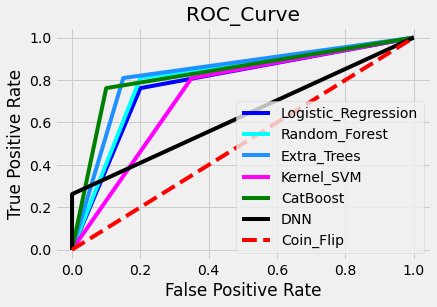

In [87]:
prob = [0 for i in range(len(y_test))]
prob_fpr, prob_tpr, threshold = roc_curve(y_test, prob, pos_label=1)

plt.plot(fpr_LR, tpr_LR, linestyle='-', color='blue', label='Logistic_Regression')
plt.plot(fpr_RFC, tpr_RFC, linestyle='-', color='cyan', label='Random_Forest')
plt.plot(fpr_ETC, tpr_ETC, linestyle='-', color='dodgerblue', label='Extra_Trees')
plt.plot(fpr_KSV, tpr_KSV, linestyle='-', color='magenta', label='Kernel_SVM')
plt.plot(fpr_CBC, tpr_CBC, linestyle='-', color='green', label='CatBoost')
plt.plot(fpr_DNN, tpr_DNN, linestyle='-', color='black', label='DNN')
plt.plot(prob_fpr, prob_tpr, linestyle='--', color='red', label="Coin_Flip")
plt.title('ROC_Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.plot(figsize=(6, 6))
plt.show()

In [88]:
Classification_Report_Summary = (pd.concat([LR_Rep_df, RFC_Rep_df, ETC_Rep_df, KSV_Rep_df, CBC_Rep_df, DNN_Rep_df],
                keys=['LR_Rep_df', 'RFC_Rep_df', 'ETC_Rep_df', 'KSV_Rep_df', 'CBC_Rep_df', 'DNN_Rep_df'])).round(decimals=2)

In [89]:
print("------ Classification Report Summary ------")

------ Classification Report Summary ------


In [90]:
Classification_Report_Summary

precision  recall  f1-score  support
LR_Rep_df  0                  0.62    0.80      0.70    20.00
           1                  0.89    0.76      0.82    42.00
           accuracy           0.77    0.77      0.77     0.77
           macro avg          0.75    0.78      0.76    62.00
           weighted avg       0.80    0.77      0.78    62.00
RFC_Rep_df 0                  0.67    0.80      0.73    20.00
           1                  0.89    0.81      0.85    42.00
           accuracy           0.81    0.81      0.81     0.81
           macro avg          0.78    0.80      0.79    62.00
           weighted avg       0.82    0.81      0.81    62.00
ETC_Rep_df 0                  0.67    0.80      0.73    20.00
           1                  0.89    0.81      0.85    42.00
           accuracy           0.81    0.81      0.81     0.81
           macro avg          0.78    0.80      0.79    62.00
           weighted avg       0.82    0.81      0.81    62.00
KSV_Rep_df 0                  0.62    0.65      0.63    20.00
           1                  0.83    0.81      0.82    42.00
           accuracy           0.76    0.76      0.76     0.76
           macro avg          0.72    0.73      0.73    62.00
           weighted avg       0.76    0.76      0.76    62.00
CBC_Rep_df 0                  0.64    0.90      0.75    20.00
           1                  0.94    0.76      0.84    42.00
           accuracy           0.81    0.81      0.81     0.81
           macro avg          0.79    0.83      0.80    62.00
           weighted avg       0.84    0.81      0.81    62.00
DNN_Rep_df 0                  0.39    1.00      0.56    20.00
           1                  1.00    0.26      0.42    42.00
           accuracy           0.50    0.50      0.50     0.50
           macro avg          0.70    0.63      0.49    62.00
           weighted avg       0.80    0.50      0.46    62.00

In [91]:
OUTFILE = r"MLM_Evaluation_Clf.xlsx"

writer = pd.ExcelWriter(f"{OUTPATH}{PREFIX}{OUTFILE}", engine='xlsxwriter', options={'strings_to_numbers': True})
summary.to_excel(writer, sheet_name='MLM_Summary', index=False)
Classification_Report_Summary.to_excel(writer, sheet_name='CLF_Summary', index=True)
writer.save()

In [99]:
explainer = shap.TreeExplainer(ETC) # Only works for tree based models such as DTC, RFC, ETC, CatBoost 
shap_values = explainer.shap_values(X_train_sc)

In [100]:
print("------ Feature Importance Using SHAP ------")

------ Feature Importance Using SHAP ------


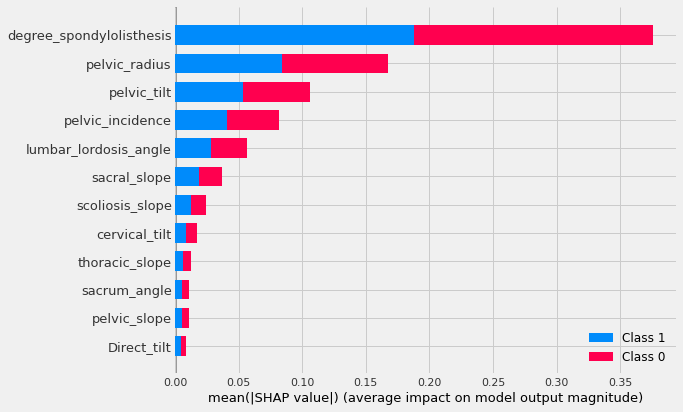

In [109]:
shap.summary_plot(shap_values, X_train_sc, feature_names=featlst, plot_type='bar', max_display=len(featlst))

In [110]:
!jupyter nbconvert --output-dir="C:\DSML_Case_Studies\01_Classification\00_Final_Reports" MLM_CLF_Dataset_Back_Pain_R2.ipynb --to html --no-input

[NbConvertApp] Converting notebook MLM_CLF_Dataset_Back_Pain_R2.ipynb to html
[NbConvertApp] Writing 718441 bytes to C:\DSML_Case_Studies\01_Classification\00_Final_Reports\MLM_CLF_Dataset_Back_Pain_R2.html
